In [2]:
import pandas as pd
import numpy as np


import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Notes and Questions:
* Every comment has 10 unique annotators that label a comment toxic/not toxic and give it a score of toxicity
    * Should I feed the model the same comment with different classifications? Or should I only have the dataset contain one of each comment with the associtated label. The label would be the computed average of each unique annotator's toxicity score with >= 0.5 classified as "Toxic" and < 0.5 being "Non-Toxic"
* Strong class imbalance
* Should I be removing stop-words from data when considering Sequence to Sequence models?

In [3]:
comments = pd.read_csv('data/toxicity_annotated_comments.tsv', sep='\t', index_col = 0)
annotations = pd.read_csv('data/toxicity_annotations.tsv',  sep='\t')
demographics = pd.read_csv('data/toxicity_worker_demographics.tsv', sep='\t')

In [6]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
8953.0,Elected or Electoral? JHK,2002,False,article,random,test
26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [7]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [14]:
counter = 0
longest_comment = 0
for comment in comments["comment"]:
#     print(comment)
#     print('\n\n\n')
#     if counter == 10:
#         break
#     counter += 1

    longest_comment = (len(comment), comment) if len(comment) > longest_comment else longest_comment

print(max_com_len)

5000


In [151]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['toxicity'].mean() > 0.5

In [152]:
# comments = comments.groupby('rev_id')
# join labels and comments
comments['is_toxic'] = labels

In [153]:
comments.head()

,comment,year,logged_in,ns,sample,split,is_toxic
rev_id,,,,,,,
2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,False
4216.0,` :Clarification for you (and Zundark's righ...,2002,True,user,random,train,False
8953.0,Elected or Electoral? JHK,2002,False,article,random,test,False
26547.0,`This is such a fun entry. Devotchka I once...,2002,True,article,random,train,False
28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,False


In [154]:
annotations["toxicity"].unique()

array([0, 1])

In [155]:
annotations.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [156]:
# len(annotations["rev_id"].unique())
len(annotations["rev_id"])

1598289

In [157]:
annotations["toxicity_score"].unique()

array([ 0.,  1., -1.,  2., -2.])

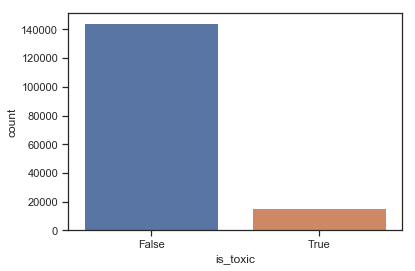

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)


len(comments["is_toxic"])

not_toxic_num = len(comments[comments["is_toxic"] == False]) 
is_toxic_num = len(comments[comments["is_toxic"] == True])


sns.countplot(x=comments["is_toxic"])



In [159]:
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


## Text PreProcessing

In [ ]:
import re, string, unicodedata
from nltk.stem import LancasterStemmer

"""
From Farhad:

def removeSpecialCharAndStopwords(self, text):
    text = re.sub(' +',' ', re.sub('[^A-Za-z0-9]+', ' ', text))
    tokens = self.tokenizer.tokenize(text)
    stopped_tokens = [i for i in tokens if not i in self.en_stop]
    return ' '.join(stopped_tokens)

"""

stemmer = LancasterStemmer()

def normalize(words):
    new_words = []
    for word in words:

        # Remove non-ASCII characters
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        # Convert all characters to lowercase from list of tokenized words
        new_word = new_word.lower()
        # Remove punctuation from list        
        new_word = re.sub(r'[^\w\s]', '', new_word)

    return new_words

# words = normalize(X_train)
comments["comment"] = comments["comment"].apply(lambda x: " ".join(normalize(x)))

In [160]:
X = comments["comment"]
y = comments["is_toxic"]

# split the dataset into training and validation datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# label encode the target  
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [161]:
X.head()

rev_id
2232.0     This: :One can make an analogy in mathematical...
4216.0     `  :Clarification for you  (and Zundark's righ...
8953.0                             Elected or Electoral? JHK
26547.0    `This is such a fun entry.   Devotchka  I once...
28959.0    Please relate the ozone hole to increases in c...
Name: comment, dtype: object

**Objective:** Detection of toxic pieces of text is an important task in moderation/flagging thoughts
provided in thoughtexchange platform. In this project we aim to build an in-house deep learning
model which could be used to apply to relatively small pieces of text and determines the toxicity
probability of that text.

**Data set:** https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973

**Data Details:** 
* Wiki: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release
* Research Paper on documentation on the data collection and modeling methodology: https://arxiv.org/abs/1610.08914
**Kaggle:** https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

**Resources:** Check the following links to get resources:
https://github.com/conversationai/perspectiveapi/blob/master/api_reference.md

**Project Description**

● Preprocessing and word embedding.
    ○ Compare using word2vec and GLoVe.

● Build a supervised framework for a two-way classifier which classifies toxic versus
healthy pieces of text.

    ○ The output of the network is a probability score between 0 and 1 representing the
    toxicity of the text.

● Apply different model architectures using the following networks to achieve the best
outputs.

    ○ Convolutional neural network.
    ○ (Bidirectional) Long short term memory.
    ○ If time allows, Investigate state of the art approaches to obtain better results.
● Use keras Platform with tensorflow backend.
    ○ Programming language: python 3.
    
● Tune the deep learning networks to improve the results.

● Compare outputs of different model architectures.
    ○ Provide precision, recall and/or sensitivity and specificity.
    ○ Provide area under the curve and/or F-score.
    
● Perform n-fold cross-validation strategy to assess the outputs.

● Apply the built models on a set of unseen labeled thoughts from thoughtexchange to
have a final evaluation of the selected method.